In [17]:
import os
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

In [18]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

In [19]:
# --------------------
# Dataset Paths
# --------------------
TRAIN_DIR = "/kaggle/input/fruit-and-vegetable-image-recognition/train"      # adapt to your dataset
VAL_DIR   = "/kaggle/input/fruit-and-vegetable-image-recognition/validation" # adapt to your dataset
TEST_DIR  = "/kaggle/input/fruit-and-vegetable-image-recognition/test"       # adapt to your dataset
NUM_CLASSES = 36  # adapt if needed

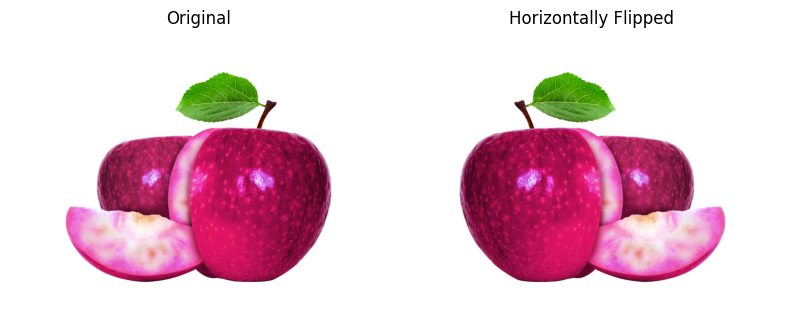

In [19]:
# Perform a horizontal flip
image = load_rgb_image("/kaggle/input/fruit-and-vegetable-image-recognition/train/apple/Image_42.jpg")
flipped_image = F.hflip(image)

# Display the original and flipped image side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(flipped_image)
axes[1].set_title("Horizontally Flipped")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [5]:
#!nvidia-smi

Mon Mar 17 12:04:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
# --------------------
# Custom Loader
# --------------------
def load_rgb_image(path):
    """Ensures images are loaded in RGB format (handles 'P' or 'RGBA')."""
    img = Image.open(path)
    if img.mode == 'P':
        img = img.convert("RGBA").convert("RGB")
    elif img.mode == 'RGBA':
        img = img.convert("RGB")
    return img

In [ ]:
old_path = os.path.join(VAL_DIR, "sweetcorn")
new_path = os.path.join(VAL_DIR, "_sweetcorn_disabled")
if os.path.exists(old_path):
    os.rename(old_path, new_path)

In [ ]:
old_path = os.path.join(TEST_DIR, "sweetcorn")
new_path = os.path.join(TEST_DIR, "_sweetcorn_disabled")
if os.path.exists(old_path):
    os.rename(old_path, new_path)

In [51]:
# --------------------
# Transforms
# --------------------
def build_transforms(img_size=150):
    return transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),
        transforms.Resize((img_size, img_size)),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomRotation(degrees=15),
        #transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        #transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

In [24]:
# --------------------
# Simple CNN Model
# --------------------
class SimpleCNN(nn.Module):
    """A simple CNN for demonstration."""
    def __init__(
        self, 
        num_conv_blocks=2, 
        filters=32, 
        kernel_size=3, 
        dropout_rate=0.0, 
        num_classes=36,
        image_size=150
    ):
        super().__init__()
        self.layers = nn.ModuleList()
        in_channels = 3
        for i in range(num_conv_blocks):
            out_channels = filters * (2 ** i)
            self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding="same"))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.MaxPool2d(2))
            in_channels = out_channels

        # compute final flatten size
        factor = 2 ** num_conv_blocks
        flat_dim = out_channels * (image_size // factor) * (image_size // factor)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flat_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc2(x)


In [25]:

# --------------------
# Lightning Module
# --------------------
class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # read hyperparams from wandb.config
        self.num_conv_blocks = wandb.config.num_conv_blocks
        self.filters         = wandb.config.filters
        self.kernel_size     = wandb.config.kernel_size
        self.dropout_rate    = wandb.config.dropout_rate
        self.learning_rate   = wandb.config.learning_rate
        self.image_size      = wandb.config.image_size
        self.num_classes     = NUM_CLASSES

        # define model
        self.model = SimpleCNN(
            num_conv_blocks=self.num_conv_blocks,
            filters=self.filters,
            kernel_size=self.kernel_size,
            dropout_rate=self.dropout_rate,
            num_classes=self.num_classes,
            image_size=self.image_size
        )

        self.criterion = nn.CrossEntropyLoss()

        # metrics
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=self.num_classes)
        self.val_acc   = torchmetrics.Accuracy(task='multiclass', num_classes=self.num_classes)
        self.test_acc  = torchmetrics.Accuracy(task='multiclass', num_classes=self.num_classes)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss   = self.criterion(logits, y)
        preds  = torch.argmax(logits, dim=1)
        self.train_acc.update(preds, y)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss   = self.criterion(logits, y)
        preds  = torch.argmax(logits, dim=1)
        self.val_acc.update(preds, y)

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss   = self.criterion(logits, y)
        preds  = torch.argmax(logits, dim=1)
        self.test_acc.update(preds, y)

        if batch_idx == 0 and not hasattr(self, "misclassified_table"):
            # Create a table with desired columns
            self.misclassified_table = wandb.Table(columns=["image", "true_label", "pred_label"])
        
        # Check which samples are wrong
        wrong_idx = (preds != y).nonzero(as_tuple=True)
        for idx in wrong_idx[0]:
            # Convert the PyTorch tensor (CHW) to a format for wandb.Image (HWC or PIL)
            img_array = x[idx].cpu().numpy().transpose(1, 2, 0)
            
            # Add a row for each misclassified example
            self.misclassified_table.add_data(
                wandb.Image(img_array, caption=f"Pred={preds[idx].item()}, GT={y[idx].item()}"),
                y[idx].item(),
                preds[idx].item()
            )

        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("test_acc", self.test_acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    def on_test_end(self):
        # Finally log the table after the entire test set
        wandb.log({"wrong_predictions": self.misclassified_table})

In [26]:
class MemoryUsageCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        """Called at the end of each training epoch."""
        device_idx = 1  # or whichever GPU index you’re using
        used_bytes = torch.cuda.memory_allocated(device=device_idx)
        used_mb = used_bytes / (1024**2)
        # Log to W&B using the current epoch as the step
        wandb.log({"gpu_memory_mb": used_mb}, step=trainer.current_epoch)

In [40]:
from torchvision.datasets import ImageFolder
class PartialImageFolder(ImageFolder):
    def find_classes(self, directory):
        classes, class_to_idx = super().find_classes(directory)
        # filter out sweetcorn
        classes = [c for c in classes if c != "sweetcorn"]
        class_to_idx = {c: i for i, c in enumerate(classes)}
        return classes, class_to_idx

In [52]:
# --------------------
# Train Function
# --------------------
def train():
    wandb.init()  # each run of the sweep is a new W&B run
    

    # read more config
    batch_size   = wandb.config.batch_size
    image_size   = wandb.config.image_size
    max_epochs   = wandb.config.max_epochs
    num_workers  = wandb.config.num_workers
    wandb.run.name = f"Kadyrzhan Data Augmentation Colour No SweetCorn"

    # data transforms
    transform = build_transforms(img_size=image_size)

    # datasets
    train_ds = PartialImageFolder(TRAIN_DIR, loader=load_rgb_image, transform=transform)
    val_ds   = PartialImageFolder(VAL_DIR,   loader=load_rgb_image, transform=transform)
    test_ds  = PartialImageFolder(TEST_DIR,  loader=load_rgb_image, transform=transform)

    # loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, 
                              num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, 
                              num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)

    # define model & trainer
    model = LitModel()

    #memory_callback = MemoryUsageCallback()
    
    wandb_logger = WandbLogger(entity="25DLAAU", project="Miniproject", log_model=False)
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",
        devices=1,
        logger=wandb_logger,
        #callbacks=[memory_callback]
    )

    

    # fit & test
    trainer.fit(model, train_loader, val_loader)
    root_device = trainer.strategy.root_device
    print(f"Trainer is using device: {root_device}")
    trainer.test(model, test_loader)

    wandb.finish()


In [53]:
# --------------------
# Sweep Config
# --------------------
sweep_config = {
    'name': "Batch",
    'description': "Changine Batch Size",
    'method': 'grid',
    'metric': {
    'name': 'val_acc',
    'goal': 'maximize'
    },
    'early_terminate': {
    'type': 'hyperband',
    'min_iter': 3,
    'eta': 3
    },
    'parameters': {
        'learning_rate': {
            'value': 1e-3
        },
        'dropout_rate': {
            'value': 0
        },
        'num_conv_blocks': {
            'value': 2
        },
        'filters': {
            'value': 32
        },
        'kernel_size': {
            'value': 3
        },
        'batch_size': {
            'value': 8
        },
        'image_size': {
            'value': 150
        },
        'max_epochs': {
            'value': 10
        },
        'num_workers': {
            'value': 4
        }
    }
}

In [54]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Wandb")
os.environ["WANDB_API_KEY"] = secret_value_0

In [55]:
# --------------------
# Run Everything
# --------------------

# 1) Log in to wandb
wandb.login(key=secret_value_0)  # make sure you are logged in; may prompt or use your env key

# 2) Create the sweep
sweep_id = wandb.sweep(
    sweep=sweep_config, 
    project="Miniproject", 
    entity="25DLAAU"
)
print("Create sweep with ID:", sweep_id)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: ygb6vjg7
Sweep URL: https://wandb.ai/25DLAAU/Miniproject/sweeps/ygb6vjg7
Create sweep with ID: ygb6vjg7


In [ ]:
wandb.agent(sweep_id, function=train, count=4)

wandb: Agent Starting Run: jt74y0vl with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0
wandb: 	filters: 32
wandb: 	image_size: 150
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_conv_blocks: 2
wandb: 	num_workers: 4


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]